## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# import seaborn as sns
# sns.set()

import pandas as pd

import time

import random

import os

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

sys.path.append("/home/jovyan/gen-mod-vol/avlab/manifolder/code")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
import pickle
#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [7]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,[0,5]]
        #snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
snippet size (1440, 2) with goal 1.0
snippet size (1440, 2) with goal 0.0
s

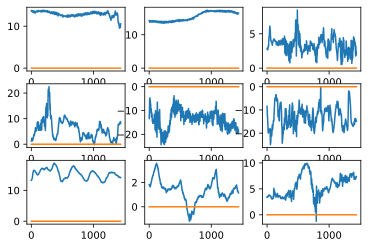

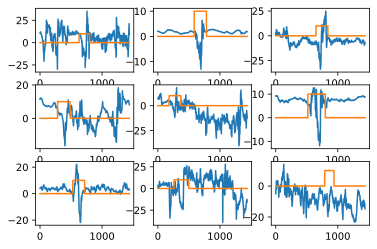

In [8]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [9]:
# data has been parsed, now run Manifolder

dim=6
H = 160
step_size = 20
nbins = 10
ncov = 10
rdims = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov, num_rdims=rdims)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=True)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


Calculating histograms in parallel ... done in  7.01 seconds!
Computing local covariances in parallel ... done in  2.38 seconds!
using 4000 for variable m
computing Dis matrix in parallel
Python version is >= 3.8, using shared memory
done in  15.42 seconds!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 33.61 seconds


import pickle
with open('manifolder_multidim_6.pickle', 'wb') as f:
    pickle.dump(manifolder, f)


In [10]:
# calculate energy distance matrix for dimension reduced data from manifolder

snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)


	 Dcor Executed in 1.34 seconds
[[0.     0.7234 3.2388 ... 3.2303 3.525  2.5754]
 [0.7234 0.     3.8843 ... 3.8583 4.4557 3.3158]
 [3.2388 3.8843 0.     ... 0.6065 2.8877 1.1397]
 ...
 [3.2303 3.8583 0.6065 ... 0.     2.7383 0.5492]
 [3.525  4.4557 2.8877 ... 2.7383 0.     2.7171]
 [2.5754 3.3158 1.1397 ... 0.5492 2.7171 0.    ]]


In [11]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 6)


class EmptyObject:
    pass

results = EmptyObject()
#results.manifolder = manifolder
results.psi = manifolder.Psi
results.dcor_dm = dcor_dm
results.locallabel_downsample = locallabel_downsample
print(results.dcor_dm.shape)
import pickle
try:
    pfile = open(".\clusteringResults.pickle", "wb+")
    pickle.dump(results, pfile)
    pfile.close()
    print("Pickle file written successfully")
except Exception as ex:
    print(ex)
    print("Unable to write pickle file")
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

In [12]:
# kmedoids clustering function
# build list of index pairs for the initial medoids
tot = 104 #len(zs)
idx = []
for i1 in range(tot):
    for j1 in range((tot-1)):
        temp = [i1,j1]
        idx.append(temp)
print(len(idx))

from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm, idx=None):
    len_data = dm.shape[0]
    if idx == None:
        idx = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, idx, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

10712


In [15]:
# calculate euclidean distance matrix for original data

euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance
print(euclid_dm)

[[  0.     141.231  377.8142 ... 600.1051 222.5719 429.6227]
 [141.231    0.     486.033  ... 706.3331 232.4725 459.8959]
 [377.8142 486.033    0.     ... 300.2353 488.6204 408.741 ]
 ...
 [600.1051 706.3331 300.2353 ...   0.     671.4759 539.2375]
 [222.5719 232.4725 488.6204 ... 671.4759   0.     515.9217]
 [429.6227 459.8959 408.741  ... 539.2375 515.9217   0.    ]]


In [16]:
# kmedoids clustering using Euclidean distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, euclid_dm, idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")



########################################################################
before sorting
[[[[2, 4, 5, 7, 11, 12, 14, 15, 18, 19, 21, 22, 23, 28, 32, 33, 34, 38, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 67, 68, 70, 71, 75, 76, 77, 78, 80, 81, 82, 84, 85, 92, 93, 94, 95, 98, 99, 100, 101], [0, 1, 3, 6, 8, 9, 10, 13, 16, 17, 20, 24, 25, 26, 27, 29, 30, 31, 35, 36, 37, 39, 40, 46, 47, 52, 62, 65, 66, 69, 72, 73, 74, 79, 83, 86, 87, 88, 89, 90, 91, 96, 97, 102, 103]], 10712]]
after sorting
[[[[2, 4, 5, 7, 11, 12, 14, 15, 18, 19, 21, 22, 23, 28, 32, 33, 34, 38, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 67, 68, 70, 71, 75, 76, 77, 78, 80, 81, 82, 84, 85, 92, 93, 94, 95, 98, 99, 100, 101], [0, 1, 3, 6, 8, 9, 10, 13, 16, 17, 20, 24, 25, 26, 27, 29, 30, 31, 35, 36, 37, 39, 40, 46, 47, 52, 62, 65, 66, 69, 72, 73, 74, 79, 83, 86, 87, 88, 89, 90, 91, 96, 97, 102, 103]], 10712]]
##############################################

In [17]:
# get results over all Monte Carlo bins for Euclidean

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative = 0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[2, 4, 5, 7, 11, 12, 14, 15, 18, 19, 21, 22, 23, 28, 32, 33, 34, 38, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 67, 68, 70, 71, 75, 76, 77, 78, 80, 81, 82, 84, 85, 92, 93, 94, 95, 98, 99, 100, 101], [0, 1, 3, 6, 8, 9, 10, 13, 16, 17, 20, 24, 25, 26, 27, 29, 30, 31, 35, 36, 37, 39, 40, 46, 47, 52, 62, 65, 66, 69, 72, 73, 74, 79, 83, 86, 87, 88, 89, 90, 91, 96, 97, 102, 103]]
TN: 23
FP: 36
TP: 21
FN: 24


In [13]:
# kmedoids clustering using manifolder+energy distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dcor_dm, idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) \
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


########################################################################
before sorting
[[[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 14, 15, 18, 21, 28, 44, 45, 49, 55, 64, 75, 93, 95]], 7820], [[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 15, 32, 44, 51, 75, 92, 93]], 2892]]
after sorting
[[[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

In [14]:
# get results over all Monte Carlo bins for manifolder with energy distance

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 14, 15, 18, 21, 28, 44, 45, 49, 55, 64, 75, 93, 95]]
TN: 38
FP: 51
TP: 6
FN: 9
[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 15, 32, 44, 51, 75, 92, 93]]
TN: 42
FP: 53
TP: 4
FN: 5


In [ ]:
#kmedoids clustering using dtw, summing each dimension

from pyclustering.cluster.kmedoids import kmedoids
import pickle

try:
    f = open("dtw_distmat_snippets_all_dims_sum.pickle", 'rb')
    dtw_distmat_all_dims_sum = pickle.load(f)
finally:
    f.close()

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dtw_distmat_all_dims_sum, idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


In [ ]:
# kmedoids clustering using joint dtw

import pickle

try:
    f = open("dtw_distmat_snippets_all_dims.pickle", 'rb')
    dtw_distmat_all_dims = pickle.load(f)
finally:
    f.close()

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dtw_distmat_all_dims, idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


In [18]:
snippet_windows = []

# create windows for multivariate energy distance
for snip in range(len(zs)):
    z = zs[snip]
    num_dims = z.shape[1]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range*num_dims))
    #print(window.shape)
    for dim in range(num_dims):
        for i in range(i_range):
            # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
            interval = z[i * step_size:i * step_size + H, dim]
            #print(interval.shape)
            window[:,dim+i*num_dims] = interval[:]
    snippet_windows.append(window)

print(snippet_windows)


import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
#snippet_windows = manifolder.get_windows()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)

[array([[13.73,  2.28, 13.6 , ...,  1.37, 12.38,  0.49],
       [13.75,  2.32, 13.6 , ...,  1.23, 12.36,  0.45],
       [13.69,  2.27, 13.66, ...,  1.2 , 12.44,  0.51],
       ...,
       [13.44,  1.97, 13.66, ..., -0.43, 10.06, -1.74],
       [13.52,  2.04, 13.55, ..., -0.6 ,  9.95, -1.83],
       [13.62,  2.14, 13.45, ..., -0.59,  9.8 , -1.97]]), array([[14.26,  1.37, 14.01, ...,  4.01, 17.02,  4.07],
       [14.28,  1.4 , 13.98, ...,  4.1 , 17.01,  4.05],
       [14.22,  1.37, 13.86, ...,  4.1 , 17.09,  4.14],
       ...,
       [13.88,  1.  , 13.75, ...,  3.67, 16.27,  3.4 ],
       [13.78,  0.91, 13.78, ...,  3.56, 16.33,  3.44],
       [13.71,  0.83, 13.77, ...,  3.57, 16.4 ,  3.5 ]]), array([[ 2.8 , -1.83,  3.18, ..., -0.62,  2.55, -1.12],
       [ 2.83, -1.85,  3.26, ..., -0.7 ,  2.54, -1.24],
       [ 2.83, -1.88,  3.07, ..., -0.77,  2.64, -1.14],
       ...,
       [ 3.68, -0.64,  3.5 , ...,  0.55,  3.58,  0.86],
       [ 3.71, -0.6 ,  3.49, ...,  0.63,  3.46,  0.6 ],
       


	 Dcor Executed in 44.16 seconds
[[    0.      3917.0073 11278.1283 ... 17581.7517  3872.9323  9698.9429]
 [ 3917.0073     0.     14923.8597 ... 21147.5432  4626.092  10592.6774]
 [11278.1283 14923.8597     0.     ...  6441.0541 11819.051   8384.4618]
 ...
 [17581.7517 21147.5432  6441.0541 ...     0.     16779.8473 11684.6972]
 [ 3872.9323  4626.092  11819.051  ... 16779.8473     0.      9363.0563]
 [ 9698.9429 10592.6774  8384.4618 ... 11684.6972  9363.0563     0.    ]]


In [19]:
# kmedoids clustering using energy distance

from pyclustering.cluster.kmedoids import kmedoids

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dcor_dm, idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[0, 1, 2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 35, 36, 37, 39, 40, 41, 42, 46, 47, 52, 53, 58, 59, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 79, 82, 83, 86, 87, 88, 89, 90, 91, 94, 96, 97, 102, 103], [4, 5, 7, 14, 15, 18, 21, 22, 28, 32, 33, 34, 38, 43, 44, 45, 48, 49, 50, 51, 54, 55, 56, 57, 60, 61, 64, 70, 75, 76, 77, 78, 80, 81, 84, 85, 92, 93, 95, 98, 99, 100, 101]], 5068], [[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 14, 15, 18, 21, 28, 32, 44, 45, 49, 51, 55, 64, 75, 92, 93, 95]], 5644]]
[[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 5

In [ ]:
#cross-check of DTW versus Matlab

import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)

In [ ]:
# Not used

from sklearn.cluster import KMeans
singledim = []
singleDimNumber = 0
for snippet in zs:
    singledim.append(snippet[:,singleDimNumber])

results = []
for i in range(1000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)